In [1]:
# Import required libraries
import torch

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import yfinance as yf

In [3]:
# Got this data from "https://www.nseindia.com/reports-indices-historical-index-data".
# Need a better way to this. Ideally should work for any  user input ticker with any user input time frame.
df = pd.read_csv('/Users/shidhesh/Desktop/Projects/MLProjects/LLM_for_StockPrice_Prediction/Bigram/data/NIFTY 50_Historical_PR_24092022to24092024.csv')
df.head()
# convert the csv file into a dataframe.

,Index Name,Date,Open,High,Low,Close
0,NIFTY 50,23 Sep 2024,25872.55,25956.00,25847.35,25939.05
1,NIFTY 50,20 Sep 2024,25525.95,25849.25,25426.60,25790.95
2,NIFTY 50,19 Sep 2024,25487.05,25611.95,25376.05,25415.80
3,NIFTY 50,18 Sep 2024,25402.40,25482.20,25285.55,25377.55
4,NIFTY 50,17 Sep 2024,25416.90,25441.65,25352.25,25418.55


In [6]:
# df = yf.download("^NSEBANK", start = '2022-09-24', end = '2024-09-23')
# df.head()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ^NSEBANK: No timezone found, symbol may be delisted


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [4]:
# Add two new columns
df['Change'] = 0
df['Percent Change'] = 0

In [6]:
# populate both the columns with daily change and percent change.
df['Change'] = df['Close']-df['Close'].shift(-1)

In [8]:
df['Percent Change'] = df['Change']/df['Close'].shift(-1)*100

In [9]:
# Tokenize. Put percent change in pre defined bins.
df['Token'] = 0
bins = [-10,-5,-2.5,-1,-0.25,0.25,1,2.5,5]
label = [0,1,2,3,4,5,6,7]
df['Token'] = pd.cut(df['Percent Change'], bins = bins, labels = label)

In [10]:
len(df)

495

In [17]:
# Input data
data = (list(df['Token'])[-2::-1])

In [18]:
data[:5]

[4, 3, 4, 6, 2]

In [19]:
N = torch.zeros((8,8), dtype = torch.int32)

In [20]:
# Bigram matrix
for d1, d2 in zip(data, data[1:]):
    N[d1,d2] +=  1

In [21]:
N = N.float()

In [22]:
N

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  3., 10.,  5.,  6.,  5.,  0.],
        [ 0.,  0.,  7., 24., 34., 33.,  9.,  0.],
        [ 0.,  0., 12., 32., 46., 60.,  9.,  1.],
        [ 0.,  0.,  6., 36., 60., 50.,  8.,  0.],
        [ 0.,  0.,  2.,  4., 14., 11.,  1.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])

In [23]:
# Convert each row as probabilty distribution.
prob = N/torch.sum(N, 1, keepdim =True)

In [31]:
# Each loop predicts the next token by 
# pulling elememts as per the probability disribution given by current token row.
# Then the percent change is selected uniformly from the selected bin/token.
idx = 4
curr = df['Close'][-1:].item()
pred = [curr]
for _ in range(494):
    curr = ((random.uniform(bins[idx],bins[idx+1]))/100 + 1)*curr
    pred.append(curr)
    idx = torch.multinomial(prob[idx], num_samples = 1, replacement = True).item()
    

In [32]:
len(pred)

495

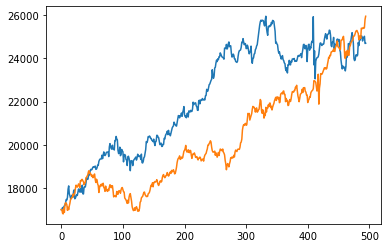

In [33]:
# Plots and compares the predicted price movement (blue) to the actual price movement(orange)
plt.plot(pred)
plt.plot(range(495),df['Close'][::-1])
plt.show()
# This is just one instance. Technically this should be repeated multiple times to gather general statistics.
# To be continued ...